In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices()
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[3], True)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print(tf.__version__)

2.3.2


In [3]:
import os
from tensorflow_addons.optimizers import ExponentialCyclicalLearningRate
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Input, Add, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import wandb
from wandb.keras import WandbCallback

In [4]:
# run = wandb.init(project = "FACIAL_LANDMARKS")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
LEARNING_RATE = 0.00025
NUM_EPOCH = 10

In [6]:
images = np.load("face_images.npy")
images = np.expand_dims(np.transpose(images, (2,0,1)), axis = 3)/255.0
labels = np.genfromtxt("facial_keypoints.csv", delimiter = ",")
labels = labels[1:,:]

In [7]:
images.shape, labels.shape

((7049, 96, 96, 1), (7049, 30))

In [8]:
images_test = images[6000:,:,:]
labels_test = labels[6000:,:]

In [9]:
x = []
y = []
for i in range(len(images)):
    NAN_FOUND = False
    for j in range(len(labels[i,:])):
        
        
        if np.isnan(labels[i, j]):
            
            NAN_FOUND = True
            break
    if NAN_FOUND:
        continue
    
    x.append(images[i])
    y.append(labels[i])

images = np.array(x)
labels = np.array(y)
del x
del y
print(f"After nan filteration image numpy array is of shape: {images.shape}")
print(f"After nan filteration label numpy array is of shape: {labels.shape}")

After nan filteration image numpy array is of shape: (2140, 96, 96, 1)
After nan filteration label numpy array is of shape: (2140, 30)


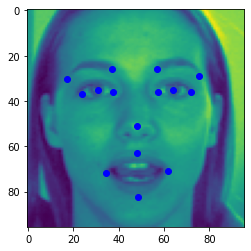

In [10]:
index = 30
for i in range(0, 29, 2):
    plt.scatter(labels[index, i], labels[index, i+1], color = "b")
plt.imshow(images[index,:,:,:])

In [11]:
TRAIN_SAMPLES = 1900

train_ds = tf.data.Dataset.from_tensor_slices((images[:TRAIN_SAMPLES,:,:,:], labels[:TRAIN_SAMPLES,:]))
val_ds = tf.data.Dataset.from_tensor_slices((images[TRAIN_SAMPLES:,:,:,:], labels[TRAIN_SAMPLES:,:]))
print(len(train_ds), len(val_ds))

def configure_for_performance(ds):
    ds = ds.cache(filename = "cache")
    ds = ds.shuffle(buffer_size=200, reshuffle_each_iteration = True)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.repeat(NUM_EPOCH)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
print(len(train_ds), len(val_ds))
TRAIN_STEPS_PER_EPOCH = round(len(train_ds)/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = round(len(val_ds)/BATCH_SIZE)
TRAIN_STEPS_PER_EPOCH

1900 240
1190 150


74

In [12]:
def get_model():
    x_input = Input((96, 96, 1))
    x = Conv2D(32, (5, 5), padding = "valid", kernel_initializer= "he_normal")(x_input)
    x = tf.nn.relu(x)
    x = Conv2D(64, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x_ = tf.nn.relu(x)
    x = Conv2D(64, (3, 3), padding = "same",kernel_initializer = "he_normal")(x_)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Conv2D(64, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x = Add()([x, x_])
    x = tf.nn.relu(x)
    x = Conv2D(128, (3, 3), padding = "valid",strides = 2,kernel_initializer = "he_normal")(x)
    x = BatchNormalization()(x)
    x_ = tf.nn.relu(x)
    x = Conv2D(128, (3, 3), padding = "same",kernel_initializer = "he_normal")(x_)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Conv2D(128, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x = Add()([x, x_])
    x = Dropout(0.1)(x)
    x = Conv2D(256, (3, 3), padding = "valid",strides = 2,kernel_initializer = "he_normal")(x)
    x_ = tf.nn.relu(x)
    x = Conv2D(256, (3, 3), padding = "same",kernel_initializer = "he_normal")(x_)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Conv2D(256, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x = Add()([x, x_])
    x = Conv2D(512, (3, 3), padding = "valid",strides = 2,kernel_initializer = "he_normal")(x)
    x_ = tf.nn.relu(x)
    x = Conv2D(512, (3, 3), padding = "same",kernel_initializer = "he_normal")(x_)
    x = tf.nn.relu(x)
    x = Conv2D(512, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x = Add()([x, x_])
    x = Dropout(0.1)(x)
    x = Conv2D(512, (3, 3), padding = "valid",strides = 2,kernel_initializer = "he_normal")(x)
    x = BatchNormalization()(x)
    x_ = tf.nn.relu(x)
    x = Conv2D(512, (3, 3), padding = "same",kernel_initializer = "he_normal")(x_)
    x = BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = Conv2D(512, (3, 3), padding = "same",kernel_initializer = "he_normal")(x)
    x = Add()([x, x_])
    x = tf.nn.relu(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, kernel_initializer = "he_normal", activation = "relu")(x)
    x = Dense(30, kernel_initializer = "he_normal", activation = "linear")(x) 
    return Model(inputs = x_input, outputs =x)
    

In [13]:
model = get_model()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE), loss = "mse", metrics = [tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 92, 92, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 92, 92, 32)] 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 92, 92, 64)   18496       tf_op_layer_Relu[0][0]           
_______________________________________________________________________________________

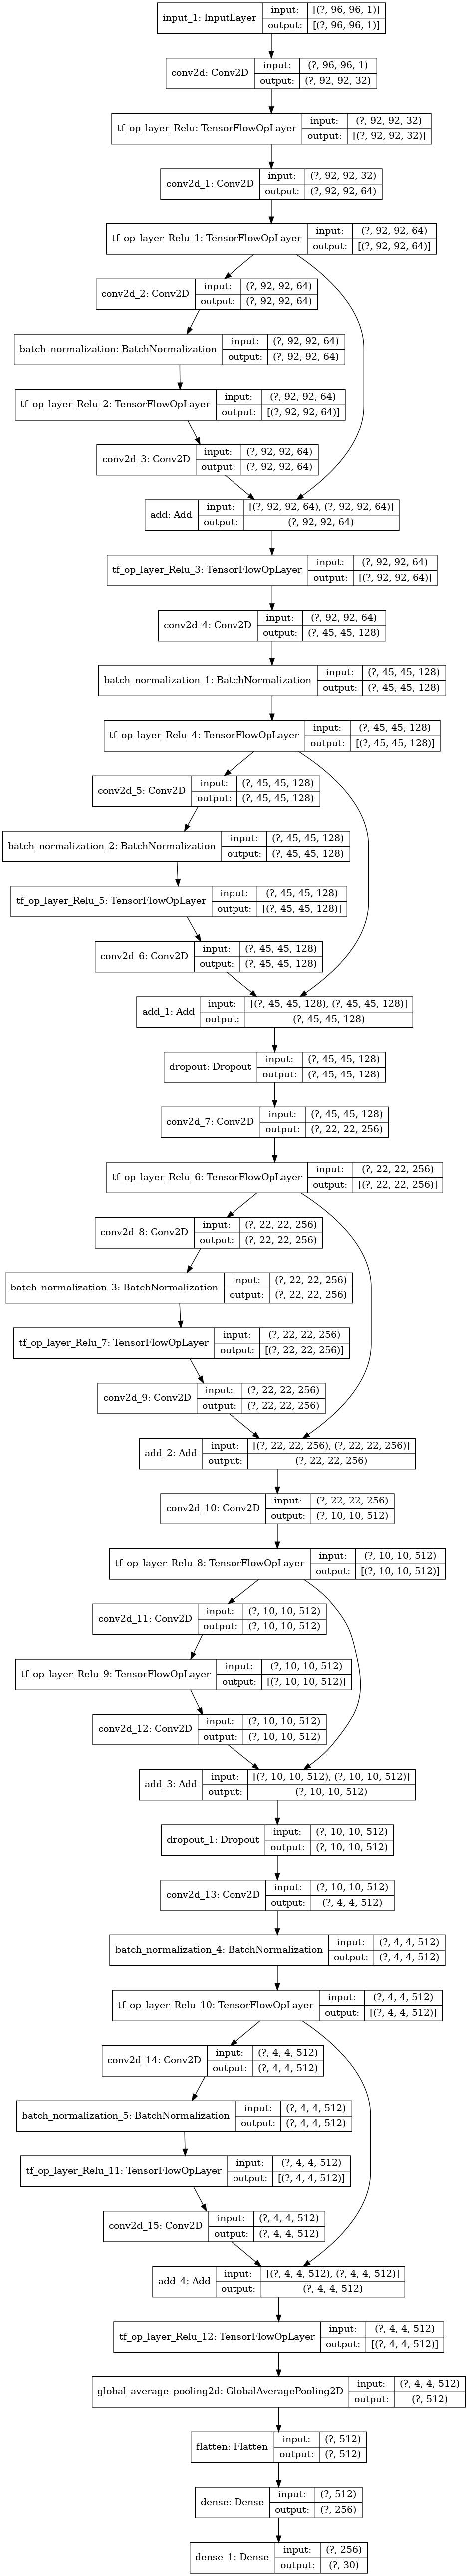

In [14]:
tf.keras.utils.plot_model(model, to_file = "model.png",show_shapes = True)

In [15]:
max_lr = 0.00008
base_lr = 1e-7


step_size = 6
def callbacks():
    
    best_path = f"{os.getcwd()}" + "/best_checkpoint_1/checkpoint"
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = best_path,
                                                         monitor = "val_loss",
                                                         verbose = 0,
                                                         mode = "min",
                                                         save_best_only = True,
                                                         save_weights_only =True,
                                                         save_freq = "epoch")
    
    
    latest_path = f"{os.getcwd()}" + "/latest_checkpoint_1/checkpoint"
    latest_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = latest_path,
                                                         monitor = "val_loss",
                                                         verbose = 0,
                                                         mode = "min",
                                                         save_best_only = False,
                                                         save_weights_only =True,
                                                         save_freq = "epoch")
    
    
#     def scheduler(epoch, lr):
#         return lr*tf.math.exp(-0.1)
    
    
#     lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)
    
    return [best_checkpoint, latest_checkpoint]
#     return [best_checkpoint, latest_checkpoint, lr_schedule, WandbCallback()]

callbacks = callbacks()

In [16]:
model.optimizer.lr = 0.00025

In [17]:
for i in range(25):
    model.fit(train_ds,
              epochs = NUM_EPOCH,
              batch_size = BATCH_SIZE,
              steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
              validation_data = val_ds,
              validation_steps = VAL_STEPS_PER_EPOCH,
              callbacks = callbacks)

Epoch 1/10
74/74 [==============================] - 13s 176ms/step - loss: 461.5071 - mean_squared_error: 461.5071 - val_loss: 7857.5513 - val_mean_squared_error: 7857.5513
Epoch 2/10
74/74 [==============================] - 13s 175ms/step - loss: 14.4116 - mean_squared_error: 14.4116 - val_loss: 40.1286 - val_mean_squared_error: 40.1286
Epoch 3/10
 2/74 [..............................] - 1s 545ms/step - loss: 13.8623 - mean_squared_error: 13.8623 - val_loss: 44.6023 - val_mean_squared_error: 44.6023
Epoch 1/10
74/74 [==============================] - 13s 175ms/step - loss: 13.7957 - mean_squared_error: 13.7957 - val_loss: 38.8009 - val_mean_squared_error: 38.8009
Epoch 2/10
74/74 [==============================] - 13s 175ms/step - loss: 13.7148 - mean_squared_error: 13.7148 - val_loss: 32.9343 - val_mean_squared_error: 32.9343
Epoch 3/10
 2/74 [..............................] - 1s 523ms/step - loss: 11.1528 - mean_squared_error: 11.1528 - val_loss: 33.6023 - val_mean_squared_error: 33

74/74 [==============================] - 13s 175ms/step - loss: 3.1943 - mean_squared_error: 3.1943 - val_loss: 13.1366 - val_mean_squared_error: 13.1366
Epoch 2/10
74/74 [==============================] - 13s 175ms/step - loss: 3.0423 - mean_squared_error: 3.0423 - val_loss: 7.1887 - val_mean_squared_error: 7.1887
Epoch 3/10
 2/74 [..............................] - 1s 706ms/step - loss: 3.2037 - mean_squared_error: 3.2037 - val_loss: 6.7917 - val_mean_squared_error: 6.7917
Epoch 1/10
74/74 [==============================] - 13s 170ms/step - loss: 2.8852 - mean_squared_error: 2.8852 - val_loss: 7.8285 - val_mean_squared_error: 7.8285
Epoch 2/10
74/74 [==============================] - 13s 175ms/step - loss: 3.0927 - mean_squared_error: 3.0927 - val_loss: 4.8819 - val_mean_squared_error: 4.8819
Epoch 3/10
 2/74 [..............................] - 1s 691ms/step - loss: 2.7099 - mean_squared_error: 2.7099 - val_loss: 4.3351 - val_mean_squared_error: 4.3351
Epoch 1/10
74/74 [===============

 2/74 [..............................] - 1s 722ms/step - loss: 1.6855 - mean_squared_error: 1.6855 - val_loss: 1.2191 - val_mean_squared_error: 1.2191
Epoch 1/10
74/74 [==============================] - 13s 170ms/step - loss: 1.6164 - mean_squared_error: 1.6164 - val_loss: 3.4005 - val_mean_squared_error: 3.4005
Epoch 2/10
74/74 [==============================] - 13s 170ms/step - loss: 1.6039 - mean_squared_error: 1.6039 - val_loss: 1.6945 - val_mean_squared_error: 1.6945
Epoch 3/10
 2/74 [..............................] - 2s 758ms/step - loss: 1.4254 - mean_squared_error: 1.4254 - val_loss: 1.0030 - val_mean_squared_error: 1.0030
Epoch 1/10
74/74 [==============================] - 13s 171ms/step - loss: 1.3290 - mean_squared_error: 1.3290 - val_loss: 1.6453 - val_mean_squared_error: 1.6453
Epoch 2/10
74/74 [==============================] - 13s 170ms/step - loss: 1.3345 - mean_squared_error: 1.3345 - val_loss: 1.2453 - val_mean_squared_error: 1.2453
Epoch 3/10
 2/74 [.................

Epoch 1/10
74/74 [==============================] - 13s 175ms/step - loss: 1.0172 - mean_squared_error: 1.0172 - val_loss: 0.7621 - val_mean_squared_error: 0.7621
Epoch 2/10
74/74 [==============================] - 13s 176ms/step - loss: 0.8518 - mean_squared_error: 0.8518 - val_loss: 0.7598 - val_mean_squared_error: 0.7598
Epoch 3/10
 2/74 [..............................] - 1s 557ms/step - loss: 0.9809 - mean_squared_error: 0.9809 - val_loss: 1.2655 - val_mean_squared_error: 1.2655
Epoch 1/10
74/74 [==============================] - 13s 171ms/step - loss: 0.7957 - mean_squared_error: 0.7957 - val_loss: 1.2332 - val_mean_squared_error: 1.2332
Epoch 2/10
74/74 [==============================] - 13s 171ms/step - loss: 0.8162 - mean_squared_error: 0.8162 - val_loss: 2.4310 - val_mean_squared_error: 2.4310
Epoch 3/10
 2/74 [..............................] - 1s 531ms/step - loss: 0.9269 - mean_squared_error: 0.9269 - val_loss: 1.9244 - val_mean_squared_error: 1.9244
Epoch 1/10
55/74 [======

KeyboardInterrupt: 

In [ ]:
# model.load_weights( f"{os.getcwd()}" + "/best_checkpoint_1/checkpoint")

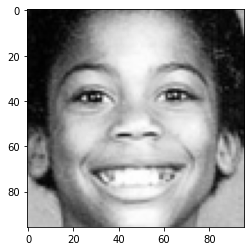

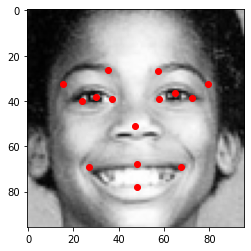

GROUND TRUTH IN BLUE
MODEL PREDICTION IN RED


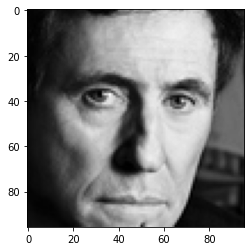

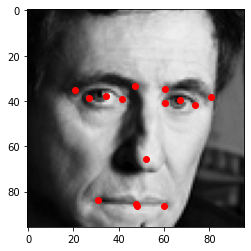

GROUND TRUTH IN BLUE
MODEL PREDICTION IN RED


In [24]:
index = 3
for x, y in val_ds.take(2):
    plt.imshow(x[index], cmap = "gray")
    plt.show()
    
    y_pred = model.predict(x)
    for i in range(0, 29, 2):
#         plt.scatter(y[index, i], y[index, i+1], color = "b")
        plt.scatter(y_pred[index, i], y_pred[index, i+1], color = "r")
    plt.imshow(x[index], cmap = "gray")
    plt.show()
    print("GROUND TRUTH IN BLUE")
    print("MODEL PREDICTION IN RED")